In [20]:
import numpy as np
from tqdm import tqdm
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F

import json
import os
import random

In [2]:
track_id2student_id_it = {7:0, 6:1, 0:2, 8:3, 1:4, 3:5, 11:6, 15:7, 16:8, 2:9, 5:12, 9:13, 4:14} # irimi tenkan, my tracking algo
track_id2student_id_ta = {8:0, 7:1, 2:2, 10:3, 3:4, 4:5, 14:6, 9:7, 1:8, 12:9, 11:10, 0:11, 6:12, 5:13} # tsugi ashi, my tracking algo
track_id2student_id_utmt = {7:0, 6:1, 1:2, 8:3, 3:4, 5:5, 11:6, 10:7, 2:8, 0:11, 4:13, 9:9, 12:10, 19:12} # utmt, my tracking algo

single_student_tids = {"1156":0, "1237":1, "0756":0, "0912":0, "1043":0}

In [3]:
file2mapping = {"../alphapose_res/irimi_tenkan_kps.json":track_id2student_id_it,
                "../alphapose_res/ta_tracking.json":track_id2student_id_ta,
                "../alphapose_res/utmt_kps.json":track_id2student_id_utmt}
annotations_map = {"../alphapose_res/irimi_tenkan_kps.json":"../data/irimi_tenkan/annotations.json",
                "../alphapose_res/ta_tracking.json":"../data/tsugi_ashi/annotations.json",
                "../alphapose_res/utmt_kps.json":"../data/ushiro_tenkan_mae_tenkan/annotations.json"}
single_st_ann = "../data/single_student_annotations.json"


SAMPLE_MAX_FRAME_COUNT = 192 # ?
THRESHOLD = 0.5
CHANNELS = 2

Код для обучения взят из ноутбука:

### https://www.kaggle.com/code/boascent/multi-label-image-classification-pytorch-gpu

# Data processing functions

In [4]:
from dataproc import *

# Датасет

In [5]:
# augmentations
def mirror_coordinate(coords:np.ndarray, coord_idx:int=0):
    """ Принимает, что координата должна быть в основном в 0...1, но может быть >1 и <0.
        Отражает относительно 0.5, меняется только в 3 размерности (coords.shape[2]), как цветовой канал. 
        Не для нормализованных данных!
        Args:
            coords, ndarray - len(coords.shape)==3
            coord_idx, int - какую координату нужно отразить
        Returns:
            np.copy(coords), но соответствующая координата отражена
    """
    new_coords = np.copy(coords)
    new_coords[:, :, coord_idx] = 1 - new_coords[:, :, coord_idx]
    return new_coords    

Собрать всё в массивы

1. Аннотации видео с толпой

In [6]:
exercise2points = dict()
exercise2errors = dict()
encoded_errors = {"нет ошибок":0}
for filename in file2mapping:
    sid2kps = parse_crowd_exercise(filename, file2mapping[filename])    
    with open(annotations_map[filename], "r", encoding="utf8") as ja:
        ann = json.load(ja)
        for k in ann:
            people = list(ann[k].keys())
            for personid in people:
                intkey = int(personid)
                ann[k][intkey] = ann[k][personid]            
    exname = os.path.basename(filename).split('.')[0]
    student_tries = split_student_tries(sid2kps, ann['people_exercise_frames'])
    errs = get_error_codes(ann, encoded_errors)
    exercise2points[exname] = student_tries
    exercise2errors[exname] = errs        

2. Аннотации видео одного ученика

In [7]:
student2points = dict()
#student2errors = dict()
with open(single_st_ann, "r", encoding="utf8") as common_ann_file:
    common_ann = json.load(common_ann_file)
ss_vid_ann = [os.path.join("../alphapose_res", f) for f in ["0756_alpha.json", "0912_alpha.json",
                                                           "1043_alpha.json", "1156_alpha.json", 
                                                            "1237_alpha.json"]]
for filename in ss_vid_ann:
    stud_id = os.path.split(filename)[-1][:4]
    dynamic = parse_single_person_exercise(filename, single_student_tids[stud_id])
    internal_vid_id = common_ann["file2id"][stud_id]
    student_tries = split_student_tries({internal_vid_id:dynamic}, common_ann['people_exercise_frames'])
    student2points[internal_vid_id] = student_tries[internal_vid_id]
student2errors = get_error_codes(common_ann, encoded_errors)

In [8]:
delete_keys = []
for ename in exercise2errors:
    for k in exercise2errors[ename]:
        if type(k) == str:
            delete_keys.append(k)
    for k in delete_keys:
        del exercise2errors[ename][k]
    delete_keys.clear()    

In [9]:
idx2error = dict()
for n in encoded_errors:
    idx = encoded_errors[n]
    idx2error[idx] = n

In [10]:
exercise2points["single_student"] = student2points
exercise2errors["single_student"] = student2errors

Dataset

In [11]:
def encode_label(label:list, class_count:int):
    target = torch.zeros(class_count)
    for idx in label:
      target[idx] = 1
    return target
    
def decode_target(target, classes:dict, threshold:float=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(classes[i])
    return result

In [23]:
class AutoEvalCNNDataset(Dataset):
    def __init__(self, images:list, labels:list, class_mapping:dict, transform, encode_target=True):
        self.transform = transform
        self.idx2class = class_mapping
        self.images = images
        self.labels = labels
        self.do_encode = encode_target

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        if self.do_encode:
            target = encode_label(label, max(self.idx2class) + 1)
        else:
            target = label
        return img, target

In [13]:
def random_mirroring(img_array:np.ndarray, channel:int, proba:float=0.5)->np.ndarray:
    if torch.rand(1) <= proba: # apply with probability
        return mirror_coordinate(img_array, channel)
    else: # else - return unchanged
        return img_array

def normalize01(img_array:np.ndarray)->np.ndarray:
    res = np.copy(img_array)
    for channel in range(res.shape[-1]):
        charr = res[:, :, channel]
        res[:, :, channel] = (charr - charr.min()) / (charr.max() - charr.min())
    return res
    
keep_1st_n_channels = lambda img_array: img_array[:, :, :CHANNELS]

train_transform = T.Compose([
    T.Lambda(keep_1st_n_channels),
    T.Lambda(lambda ar: resample_to_frame_length(ar, SAMPLE_MAX_FRAME_COUNT)),
    # T.Lambda(lambda ar: random_mirroring(ar, 0)),
    # T.Lambda(normalize01),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32)
])
val_transform = T.Compose([
    T.Lambda(keep_1st_n_channels),    
    T.Lambda(lambda ar: resample_to_frame_length(ar, SAMPLE_MAX_FRAME_COUNT)),
    #T.Lambda(normalize01),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32)
]) 

Train/Val/Test Split

In [14]:
random.seed(42)

In [48]:
def fraction_split(exercise2points:dict, exercise2errors:dict, train_frac:float, val_frac:float, test_frac:float):
    assert (train_frac + val_frac + test_frac) == 1
    train_imgs, train_labels = [], []
    test_imgs, test_labels = [], []
    val_imgs, val_labels = [], []
    
    train_ids = []
    val_ids = []
    test_ids = []
    total_data_count = 0
    for exname in exercise2points:
        cur_exerc = exercise2points[exname]
        cur_errors = exercise2errors[exname]
        for p in cur_exerc:
            tries = cur_exerc[p]
            errs = cur_errors[p]
            for i, e in enumerate(tries):
                total_data_count += 1
                rval = random.random()
                if rval <= train_frac:
                    train_imgs.append(e)
                    train_labels.append(errs[i])
                    train_ids.append((exname, p, i))
                elif rval <= (train_frac + test_frac):
                    test_imgs.append(e)
                    test_labels.append(errs[i])
                    test_ids.append((exname, p, i))
                else:
                    val_imgs.append(e)
                    val_labels.append(errs[i])
                    val_ids.append((exname, p, i))
    return [(train_imgs, train_labels), (test_imgs, test_labels), (val_imgs, val_labels)]

def pick_elems_on_indices_from_both(data, labels, indices):
    X = []
    y = []
    for i in indices:
        X.append(data[i])
        y.append(labels[i])
    return X, y

def stratify_split(exercise2points:dict, exercise2errors:dict, train_frac:float, val_frac:float, test_frac:float, class_count:int, state=0):    
    input_data = []
    labels = []
    total_count = 0
    class2idx = dict()
    for exname in exercise2points:
        cur_exerc = exercise2points[exname]
        cur_errors = exercise2errors[exname]
        for p in cur_exerc:
            tries = cur_exerc[p]
            errs = cur_errors[p]
            for i, e in enumerate(tries):
                input_data.append(e)
                labels.append(errs[i])
                #labels.append(encode_label(errs[i], class_count).numpy())
                for error in errs[i]:
                    if error not in class2idx:
                        class2idx[error] = []
                    class2idx[error].append(total_count)
                total_count += 1
    random.seed(state)
    train_instances_idx = set()
    val_instances_idx = set()
    test_instances_idx = set()
    for cl in class2idx:
        class_indices = class2idx[cl]
        random.shuffle(class_indices)
        last_train_idx = max(int(train_frac * len(class_indices)), 1)
        train_picks = class_indices[:last_train_idx]
        train_instances_idx.update(train_picks)
        if (len(class_indices) - len(train_picks)) == 0:
            continue
        last_test_idx = last_train_idx + max(int(test_frac * len(class_indices)), 1)
        test_picks = class_indices[last_train_idx:last_test_idx]
        test_instances_idx.update(test_picks)
        if (len(class_indices) - len(train_picks) - len(test_picks)) == 0:
            continue
        val_instances_idx.update(class_indices[last_test_idx:])
    # clear repeating values
    val_instances_idx = val_instances_idx - val_instances_idx.intersection(train_instances_idx)
    test_instances_idx = test_instances_idx - test_instances_idx.intersection(train_instances_idx)
    
    X_train, y_train = pick_elems_on_indices_from_both(input_data, labels, train_instances_idx)  
    X_test, y_test = pick_elems_on_indices_from_both(input_data, labels, test_instances_idx)
    X_val, y_val = pick_elems_on_indices_from_both(input_data, labels, val_instances_idx)
    
    # train_count = round(total_count * train_frac)
    # val_count = round(total_count * val_frac)
    # test_count = round(total_count * test_frac)
    # "The minimum number of groups for any class cannot be less than 2" для sklearn.model_selection.train_test_split
    # X_train, X_test, y_train, y_test = train_test_split(input_data, 
    #                                                     train_size=train_count+val_count, 
    #                                                     random_state=state, stratify=labels)
    # X_train, X_val, y_train, y_val = train_test_split(X_train, 
    #                                                   train_size=train_count, 
    #                                                   random_state=state, stratify=y_train)
    return [(X_train, y_train), (X_test, y_test), (X_val, y_val)]
                

In [49]:
# dividing
train_frac = 0.7
val_frac = 0.1
test_frac = 0.2

#train_data, test_data, val_data = fraction_split(exercise2points, exercise2errors, train_frac, val_frac, test_frac)
train_data, test_data, val_data = stratify_split(exercise2points, exercise2errors, train_frac, val_frac, test_frac, 42)
train_imgs, train_labels = train_data
test_imgs, test_labels = test_data
val_imgs, val_labels = val_data
total_data_count = len(train_imgs) + len(test_imgs) + len(val_imgs)

print("Total", total_data_count)
print("Train count", len(train_imgs))
print("Test count", len(test_imgs))
print("Val count", len(val_imgs))

Total 298
Train count 210
Test count 54
Val count 34


In [50]:
assert len(train_imgs)==len(train_labels)
assert len(test_imgs)==len(test_labels)
assert len(val_imgs)==len(val_labels)

In [51]:
train_ds = AutoEvalCNNDataset(train_imgs, train_labels, idx2error, train_transform)
val_ds = AutoEvalCNNDataset(val_imgs, val_labels, idx2error, val_transform)
test_ds = AutoEvalCNNDataset(test_imgs, test_labels, idx2error, val_transform)

Dataloader

In [52]:
# setting batch size for Dataloader to load the data batch by batch
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, 1, shuffle=False)

# Кореляция классов

In [45]:
def encode_label_list(labels:list, class_count:int)->np.ndarray:
    all_encodings = []
    for lls in labels:
        all_encodings.append(encode_label(lls, class_count).numpy())
    return np.array(all_encodings)

def show_corrs_img(corr_mat:np.ndarray, idx2error:dict):
    ticks_idx = np.arange(corr_mat.shape[0])
    error_names = [f"{idx2error[i]}({i})" for i in ticks_idx]
    plt.figure(figsize=(12, 12))
    plt.imshow(corr_mat)
    plt.xticks(ticks_idx,ticks_idx)
    plt.yticks(ticks_idx,error_names)
    for y in ticks_idx:
        for x in ticks_idx:
            if abs(corr_mat[y, x]) >= 0.2:
                plt.text(x, y, str(corr_mat[y, x]),
                         horizontalalignment='center',
                         verticalalignment='center',
                         )
    plt.title("Матрица корреляционных коэффициентов")
    plt.show()

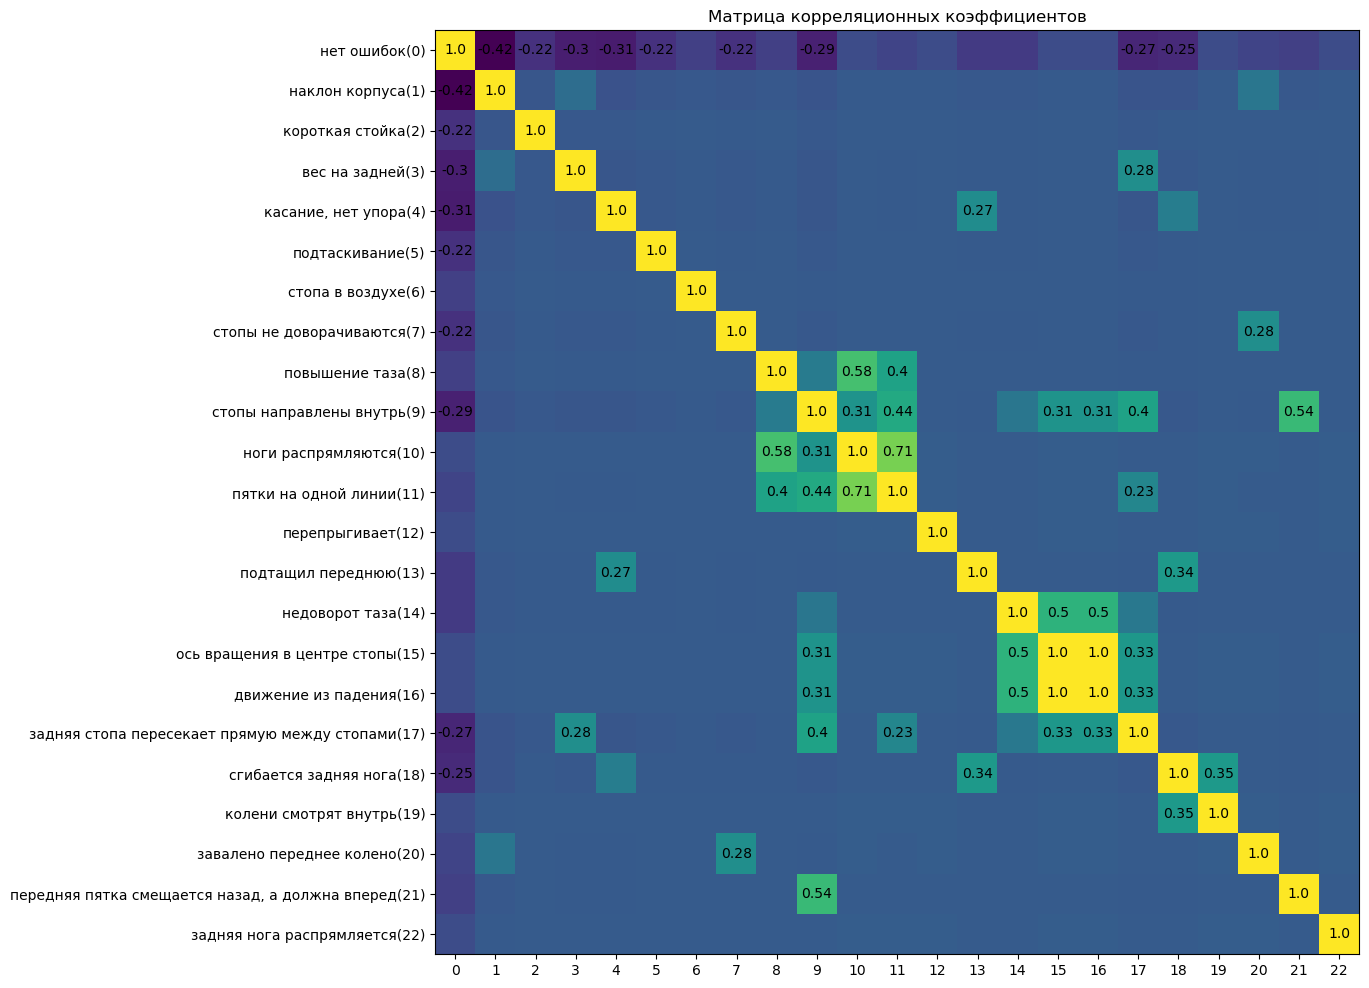

In [46]:
total_labels = train_labels + test_labels + val_labels
all_ar_labels = encode_label_list(total_labels, len(idx2error))
total_corrs = np.corrcoef(all_ar_labels, rowvar=False).round(2)
total_corrs = np.nan_to_num(total_corrs)
show_corrs_img(total_corrs, idx2error)

In [53]:
tr_ar_labels = encode_label_list(train_labels, len(idx2error))
te_ar_labels = encode_label_list(test_labels, len(idx2error))
va_ar_labels = encode_label_list(val_labels, len(idx2error))

def print_class_counts(arr_labels:np.ndarray, title:str, idx2error:dict):
    total_samples = arr_labels.shape[0]
    col0_width = max([len(idx2error[k]) for k in idx2error])
    print(title+"="*50)    
    print("{}  {:>6} | {:<6}".format("Имя класса".rjust(col0_width), "Кол-во", "Доля"))
    for class_idx in range(arr_labels.shape[1]):
        class_name = idx2error[class_idx]
        class_count = int(arr_labels[:, class_idx].sum())
        percent = round(class_count / total_samples, 3)
        print(f"{class_name.rjust(col0_width)}: {class_count:>6} | {percent:<6}")

print_class_counts(tr_ar_labels, "Классы обучения", idx2error)
print()
print_class_counts(va_ar_labels, "Классы валидации", idx2error)
print()
print_class_counts(te_ar_labels, "Классы тестирования", idx2error)

Классы обучения==================================================
                                     Имя класса  Кол-во | Доля  
                                     нет ошибок:    146 | 0.695 
                                 наклон корпуса:     15 | 0.071 
                                короткая стойка:      4 | 0.019 
                                  вес на задней:      7 | 0.033 
                             касание, нет упора:      8 | 0.038 
                                  подтаскивание:      4 | 0.019 
                                стопа в воздухе:      2 | 0.01  
                        стопы не доворачиваются:      4 | 0.019 
                                 повышение таза:      3 | 0.014 
                        стопы направлены внутрь:      8 | 0.038 
                             ноги распрямляются:      1 | 0.005 
                           пятки на одной линии:      2 | 0.01  
                                  перепрыгивает:      1 | 0.005 
                        

In [118]:
print_class_counts(all_ar_labels, "Суммарная статистика", idx2error)

Суммарная статистика==================================================
                                     Имя класса  Кол-во | Доля  
                                     нет ошибок:    209 | 0.706 
                                 наклон корпуса:     21 | 0.071 
                                короткая стойка:      6 | 0.02  
                                  вес на задней:     10 | 0.034 
                             касание, нет упора:     12 | 0.041 
                                  подтаскивание:      6 | 0.02  
                                стопа в воздухе:      3 | 0.01  
                        стопы не доворачиваются:      6 | 0.02  
                                 повышение таза:      3 | 0.01  
                        стопы направлены внутрь:      9 | 0.03  
                             ноги распрямляются:      1 | 0.003 
                           пятки на одной линии:      2 | 0.007 
                                  перепрыгивает:      1 | 0.003 
                   

# Training

In [54]:
def F_score(output, label, threshold=0.5, beta=1): #Calculate the accuracy of the model
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

class MultilabelImageClassificationBase(torch.nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                            # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        return loss    

    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_score': score.detach() }

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}    

    def epoch_end(self, epoch, result):                     # display the losses
        # print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
        #     epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

cuda


In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [28]:
# just using baseline
class ResNetWrapper(MultilabelImageClassificationBase):
    def __init__(self, num_classes, num_channels=3):
        super().__init__()     
        self.model = models.resnet50()
        self.model.conv1 = torch.nn.Conv2d(num_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        infeats = self.model.fc.in_features
        self.model.fc = torch.nn.Sequential(
            #torch.nn.Dropout(0.2),
            torch.nn.Linear(infeats, infeats//2),
            torch.nn.ReLU(),
            torch.nn.Linear(infeats//2, num_classes)
        )
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, xb):
        tmp_x = self.model(xb)
        return self.sigmoid(tmp_x)

In [29]:
model = to_device(ResNetWrapper(len(idx2error), CHANNELS), device)

Checking

In [ ]:
#checking the shape of outputs that the model will produce before starting the training process
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
history = [evaluate(model, val_dl)]
print(history)

In [30]:
epochs = 100
lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = fit(epochs, lr, model, train_dl, val_dl, opt_func=opt_func)

Showing results

In [32]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
    
def plot_losses(history, loss_name):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title(f'{loss_name} Loss vs. No. of epochs');

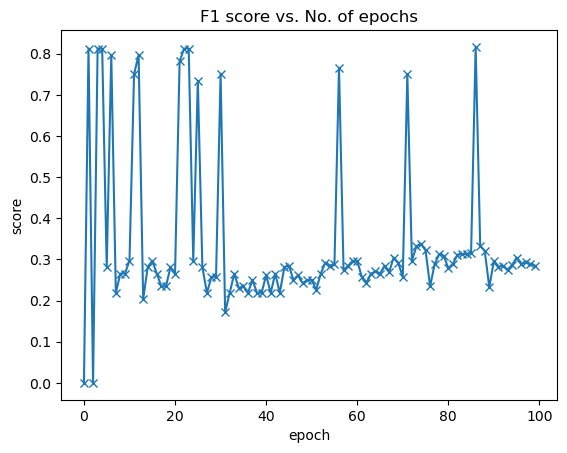

In [33]:
plot_scores(history)

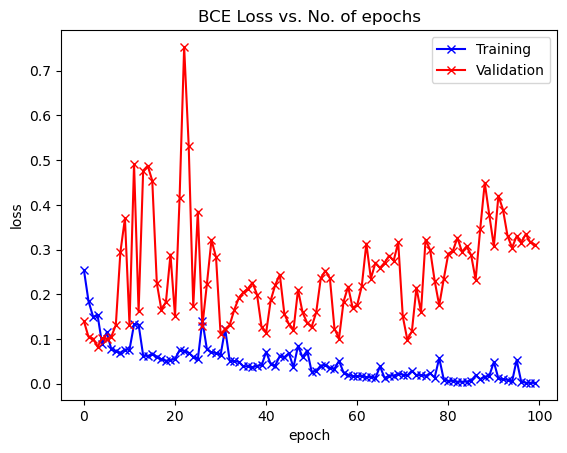

In [34]:
plot_losses(history, "BCE")

# Metrics

https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data

In [35]:
def exact_match_ratio(y_pred:np.ndarray, y_true:np.ndarray)->float:
    samples_count = y_pred.shape[0]
    return (y_true == y_pred).all(1).astype(np.float32).sum() / samples_count

def multilabel_accuracy(y_pred:np.ndarray, y_true:np.ndarray)->float: # пока равна recall
    samples_count = y_pred.shape[0]
    # intersection over union of classes
    accuracy_sum = 0.0
    for sample in range(samples_count):
        pred_sample = y_pred[sample, :]
        true_sample = y_true[sample, :]
        pred_classes = set(decode_target(pred_sample, idx2error))
        true_classes = set(decode_target(true_sample, idx2error))
        accuracy_sum += float(len(pred_classes&true_classes))/len(pred_classes|true_classes)
    return accuracy_sum / samples_count

def hamming_loss(y_pred:np.ndarray, y_true:np.ndarray)->float:
    hl_sum = (1 - y_pred[np.nonzero(y_true)]).sum()
    hl_sum += y_pred[y_true == 0].sum()
    return hl_sum / y_pred.size

# Testing

In [36]:
def show_example(img, pred_label, true_label=None):
    plt.imshow(img.permute(1,2,0))
    print("Predicted label:", decode_target(pred_label, idx2error))
    if true_label != None:
        print("True label:", decode_target(true_label, idx2error))
    print()
    print(pred_label)

def predict_single(image, label=None):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction, label)

In [37]:
model.eval()
test_dl = DeviceDataLoader(test_loader, device)

test_losses = []
test_f1s = []
preds = []
trues = []
with torch.no_grad():
    for batch in test_dl:
        images, targets = batch 
        out = model(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        score = F_score(out, targets)                 # Calculate accuracy
        test_losses.append(loss.detach().cpu().item())
        test_f1s.append(score.detach().cpu().item())
        preds.append(out.cpu().numpy())
        trues.append(targets.cpu().numpy())

In [38]:
preds_labels = []
for pred in preds:
    preds_labels.append((pred > THRESHOLD).astype(np.float32))
pred_ar = np.array(preds_labels).squeeze()
trues_ar = np.array(trues).squeeze()

In [39]:
zeros_fraction = (trues_ar == 0).astype(np.float32).sum() / trues_ar.size
print("Zeros in data:", zeros_fraction)

Zeros in data: 0.9507793273174734


Полное

In [40]:
# test_loss = np.mean(test_losses)
# testf1 = np.mean(test_f1s)
print("Test BCE loss:", np.mean(test_losses))
print("Test F1-score:", np.mean(test_f1s))

Test BCE loss: 0.45516302507081235
Test F1-score: 0.591194969303203


In [41]:
# exact match ratio
#emr = (trues_ar == pred_ar).astype(np.float32).sum() / trues_ar.size
emr = exact_match_ratio(pred_ar, trues_ar)
print("Exact match ratio:", emr)

Exact match ratio: 0.5660377358490566


In [42]:
print("Hamming loss:", hamming_loss(pred_ar, trues_ar)) # less is better

Hamming loss: 0.03691550451189499


In [43]:
print("Accuracy:", multilabel_accuracy(pred_ar, trues_ar))

Accuracy: 0.5849056603773585


In [44]:
#zero_division=0 suppresses warning
print('micro/precision:', precision_score(y_true=trues_ar, y_pred=pred_ar, average='micro', zero_division=0))
print('micro/recall', recall_score(y_true=trues_ar, y_pred=pred_ar, average='micro', zero_division=0))
print('micro/f1', f1_score(y_true=trues_ar, y_pred=pred_ar, average='micro', zero_division=0))
print('macro/precision', precision_score(y_true=trues_ar, y_pred=pred_ar, average='macro', zero_division=0))
print('macro/recall', recall_score(y_true=trues_ar, y_pred=pred_ar, average='macro', zero_division=0))
print('macro/f1', f1_score(y_true=trues_ar, y_pred=pred_ar, average='macro', zero_division=0))
print('samples/precision', precision_score(y_true=trues_ar, y_pred=pred_ar, average='samples', zero_division=0))
print('samples/recall', recall_score(y_true=trues_ar, y_pred=pred_ar, average='samples', zero_division=0))
print('samples/f1', f1_score(y_true=trues_ar, y_pred=pred_ar, average='samples', zero_division=0))

micro/precision: 0.6530612244897959
micro/recall 0.5333333333333333
micro/f1 0.5871559633027523
macro/precision 0.21929824561403508
macro/recall 0.14323357801618672
macro/f1 0.1598795672586242
samples/precision 0.6037735849056604
samples/recall 0.5849056603773585
samples/f1 0.5911949685534591


По классам отдельно

In [48]:
#def print_class_statistic(y_pred:np.ndarray, y_true:np.ndarray, class_index:dict):
print(classification_report(trues_ar, pred_ar, target_names=np.array([idx2error[i] for i in range(len(idx2error))]), zero_division=0)    )

                                                 precision    recall  f1-score   support

                                                      0.71      0.82      0.76        33
                                 наклон корпуса       1.00      0.14      0.25         7
                                короткая стойка       1.00      0.50      0.67         2
                                  вес на задней       0.00      0.00      0.00         1
                             касание, нет упора       0.00      0.00      0.00         2
                                  подтаскивание       0.00      0.00      0.00         1
                                стопа в воздухе       0.00      0.00      0.00         1
                        стопы не доворачиваются       0.00      0.00      0.00         0
                                 повышение таза       0.00      0.00      0.00         1
                        стопы направлены внутрь       1.00      0.50      0.67         2
                    